In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
import glob
import pickle
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras.layers import LeakyReLU
from keras.optimizers import Adam, Nadam
import keras
import random 
from sklearn import metrics  


In [3]:
!ls

cnn_proj_yvg_testing	       specto_hd_cnn_yvg_test_1sec_85_acc.h5
final_cnn.ipynb		       specto_hd_cnn_yvg_test_1sec_90_acc.h5
librispeech_1sec_hdpickle      specto_hd_cnn_yvg_test_1sec_91_acc.h5
librispeech_1sec_hdpickle.zip  val_acc_87_30_epoches_copy.h5
librit_1sec_hdpickle	       val_acc_87_30_epoches.h5
librit_1sec_hdpickle.zip


# the *hopefully* final pickles are pickled locally
## we only load them here
## refer to `repickle_all_final.py` on Github for the source code for final pickle
Note: final pickle pulls the 'spectrum' key of all the `.1sec_hdpickles` and aggregates them

In [4]:
def valLoad():
    DATA_PATH = "cnn_proj_yvg_testing"

    with open(os.path.join(DATA_PATH, "val_1_sec_hd_feature.pickle"), 'rb') as jar:
        x_val = pickle.load(jar)

    with open(os.path.join(DATA_PATH, "val_1_sec_hd_label.pickle"), 'rb') as jar:
        y_val = pickle.load(jar)

    print(y_val.shape)
    
    # convert to one hot
    # note: only execute once! per session!
    y_val = np.reshape(y_val, (y_val.shape[0], -1))
    y_val = to_categorical(y_val)
    print(y_val.shape)
    
    return x_val, y_val

In [5]:
!ls cnn_proj_yvg_testing

saved_models  train_1_sec_hd_feature.pickle  val_1_sec_hd_feature.pickle
subPickles    train_1_sec_hd_label.pickle    val_1_sec_hd_label.pickle


# SVM

In [6]:

# x_train_svm = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2] )


# x_val_svm = x_val.reshape(x_val.shape[0],x_val.shape[1]*x_val.shape[2] )

# print(x_train_svm.shape)

In [7]:
# from sklearn import svm
# from sklearn.metrics import accuracy_score

# clf = svm.LinearSVC()
# clf.fit(x_train_svm, y_train)
# print("train", clf.score(x_train_svm, y_train))
# y_pred = clf.predict(x_val_svm)
# score = accuracy_score(y_val, y_pred)
# print("val ", score)

In [8]:
# from sklearn.dummy import DummyClassifier

# uniform = DummyClassifier(strategy='most_frequent', random_state=2)
# uniform.fit(x_train_svm, y_train)

# print(uniform.score(x_train_svm, y_train))

# print(uniform.score(x_val_svm, y_val))

# BEGIN Only run ONCE per session!
## reshapes for the CNN

In [9]:


# # convert to one hot
# # note: only execute once! per session!
# y_val = np.reshape(y_val, (y_val.shape[0], -1))
# y_val = to_categorical(y_val)
# print(y_val.shape)


In [10]:

# # convert to one hot for training
# # note: only execute once!

# y_train = np.reshape(y_train, (y_train.shape[0], -1))
# y_train = to_categorical(y_train)
# print(y_train.shape)

# END: only run once per session


In [11]:

# new 1 sec pickles
librispeech_spectrogram_path = "librispeech_1sec_hdpickle"
librit_spectrogram_path = "librit_1sec_hdpickle"


In [12]:
!ls

cnn_proj_yvg_testing	       specto_hd_cnn_yvg_test_1sec_85_acc.h5
final_cnn.ipynb		       specto_hd_cnn_yvg_test_1sec_90_acc.h5
librispeech_1sec_hdpickle      specto_hd_cnn_yvg_test_1sec_91_acc.h5
librispeech_1sec_hdpickle.zip  val_acc_87_30_epoches_copy.h5
librit_1sec_hdpickle	       val_acc_87_30_epoches.h5
librit_1sec_hdpickle.zip


In [13]:
def data_generator(files,labels, batch_size = 1):

    nv_shape = (201, 66,1)

    while True:
        batch_features = []
        batch_labels = []
        file_index = random.randint(0,len(files)-1)
        file = files[file_index]
        label = oneHot(labels[file_index])
            
        #print("label after one hot", label)
        for i in range(batch_size):
            with open(file, 'rb') as jar:
                data_file = pickle.load(jar)
            #print(np.array(data_file['t']))

            if data_file['spectrum'].shape == (201, 66):

                batch_features.append(data_file['spectrum'].reshape(nv_shape))
                batch_labels.append(label)


            else:
                #print('small_files =',file)
                continue
                
        batch_features = np.array(batch_features)
        batch_features = batch_features.reshape((batch_size,201, 66, 1))
        
        print("yield array batch_features", batch_features.shape)
        yield batch_features, batch_labels    

In [14]:
# print(train_all_files)

In [26]:
def modelConstruct():
    model = Sequential()
    
    ###### conv layer 1 ######
    model.add(Conv2D(32, kernel_size=(4,4), input_shape=(201, 66,1),
                     kernel_initializer=keras.initializers.glorot_normal(),activation = 'relu'))

    keras.layers.BatchNormalization(axis = 0)
    model.add(MaxPooling2D(pool_size=(4,4), padding='SAME'))

    
    ###### conv 2 ##########
    model.add(Conv2D(32, kernel_size=(4,4), 
                                     kernel_initializer=keras.initializers.glorot_normal(seed=None),activation = 'relu'))
    keras.layers.BatchNormalization(axis = 0)
    model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))

    
    ###### conv 3 ##########
    model.add(Conv2D(32, kernel_size=(4,4),strides=(1, 1), padding='SAME', 
                                     kernel_initializer=keras.initializers.glorot_normal(seed=None),activation = 'relu'))

    #model.add(LeakyReLU(alpha=0.1))
    keras.layers.BatchNormalization(axis = 0)
    model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
    
    ###### conv 4 ##########
    model.add(Conv2D(32, kernel_size=(4,4),strides=(1, 1), padding='SAME', 
                                     kernel_initializer=keras.initializers.glorot_normal(seed=None),activation = 'relu'))

    #model.add(LeakyReLU(alpha=0.1))
    keras.layers.BatchNormalization(axis = 0)
    model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
    
    ### Fully connected #######
    model.add(Flatten())
    #model.add(Dense(10, activation='relu'))
    #model.add(Dense(64, activation=''relu'))

    model.add(keras.layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(Dense(2, activation='softmax'))
    
    # compile and return 
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Nadam(lr = 0.001),
                  metrics=['accuracy'])
    return model

In [16]:

def imNorm(arr):
    for i in range(arr.shape[0]):

        arr[i] -= np.min(arr[i])
        arr[i] = np.minimum(arr[i], 255)
    return arr

In [27]:
MODEL_PATH = "cnn_proj_yvg_testing/saved_models"

filepath = os.path.join(MODEL_PATH, "weights-improvement-{epoch:02d}-{loss:.4f}.h5")   
callbacks_list = [  keras.callbacks.EarlyStopping(
        monitor='val_acc', 
        patience= 10,
        mode='max',
        verbose=1),
    keras.callbacks.ModelCheckpoint(filepath,
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=0)
]


model = modelConstruct()
model.summary()

#############################################
# Use chunck loading the train data
#############################################
# load one chunck of x_train

# global count of which chunck we read
modelHistArr = []
file_path = "cnn_proj_yvg_testing/subPickles"
for i in range(5):
    # load features 
    x_name = 'x_train_splitted' + str(i) + '.pickle'
    file_name = os.path.join(file_path, x_name) 
    print("training on pickle", x_name)
    with open(file_name, 'rb') as jar:
        x_train = pickle.load(jar)
    x_train = imNorm(x_train)
    
    y_name = 'y_train_splitted' + str(i) + '.pickle'
    file_name = os.path.join(file_path, y_name)
    with open(file_name, 'rb') as jar:
        y_train = pickle.load(jar)

    y_train = to_categorical(y_train, num_classes = 2)
    modelHist2 = model.fit(x_train, y_train, validation_split = 0.1,
          batch_size=32, epochs=10, callbacks = callbacks_list)
    modelHistArr.append(modelHist2)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 63, 32)       544       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 13, 32)        16416     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 7, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 7, 32)         16416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 4, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 4, 32)         16416     
__________

Epoch 5/10
6795/6795 [==============================] - 4s 532us/step - loss: 0.1156 - acc: 0.9536 - val_loss: 0.2741 - val_acc: 0.9007
Epoch 6/10
6795/6795 [==============================] - 4s 532us/step - loss: 0.1230 - acc: 0.9535 - val_loss: 0.3338 - val_acc: 0.8874
Epoch 7/10
6795/6795 [==============================] - 4s 533us/step - loss: 0.0811 - acc: 0.9706 - val_loss: 0.2930 - val_acc: 0.9152
Epoch 8/10
6795/6795 [==============================] - 4s 531us/step - loss: 0.0713 - acc: 0.9741 - val_loss: 0.2528 - val_acc: 0.9060
Epoch 9/10
6795/6795 [==============================] - 4s 531us/step - loss: 0.0929 - acc: 0.9639 - val_loss: 0.2855 - val_acc: 0.9099
Epoch 10/10
6795/6795 [==============================] - 4s 533us/step - loss: 0.0646 - acc: 0.9750 - val_loss: 0.2952 - val_acc: 0.9192


In [18]:
x_val, y_val = valLoad()
from sklearn import metrics  
x_val = imNorm(x_val)


(4196,)
(4196, 2)


In [28]:
y_pred = model.predict(x_val)
matrix = metrics.confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
socre = metrics.confusion_matrix

from sklearn.metrics import classification_report
print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))

[[1710  234]
 [ 200 2052]]
             precision    recall  f1-score   support

          0       0.90      0.88      0.89      1944
          1       0.90      0.91      0.90      2252

avg / total       0.90      0.90      0.90      4196



In [29]:
DATA_PATH = './'
model.save(os.path.join(DATA_PATH, 'specto_hd_cnn_yvg_test_final_acc.h5'))

In [21]:

#############################################
# using the class based generator
#############################################


#no_of_train_files
#num_val = no_of_files - no_of_train_files


# modeHist2 = model.fit_generator(generator=training_generator,
#                                 validation_data=validation_generator,
#                                 callbacks = callbacks_list,
#                      steps_per_epoch=no_of_train_files // params['batch_size'] ,
#                                 epochs=5, validation_steps = no_of_val_files // params['batch_size']
#                     )



#############################################
# use the infinite loop based generator
#############################################
# batch_size = 32

# num_classes = 2
# modelHist2 = model.fit_generator(generator=data_generator(train_all_files,train_all_labels),
#                     validation_data=data_generator(val_all_files,val_all_labels),
#                  callbacks = callbacks_list,
#                 steps_per_epoch=no_of_train_files, 
#                 epochs=50, validation_steps = no_of_val_files)


In [22]:
print((modelHist2.history['acc']))

[0.8444444444356726, 0.8925680647447234, 0.9233259749816041, 0.9408388520883584, 0.9421633554083885, 0.9548197203826343, 0.9648270787782227, 0.9612950699043414, 0.968064753495217, 0.9673289183222958]


In [23]:
# consolidate arrray of model histories
historyArr = {k: [] for k in ['acc', 'loss', 'val_acc', 'val_loss']}
for i in range(len(modelHistArr)):
    for k,v in historyArr.items():
        v.extend(modelHistArr[i].history[k])
 
 

In [24]:
print((historyArr['loss']))

[1.6783900205487272, 0.5684538016870146, 0.4920061734601625, 0.44304983984292473, 0.40334937104063057, 0.36129529464762383, 0.3322003577148502, 0.296216050408797, 0.25900801140390134, 0.23127189235127174, 0.4252790199429608, 0.3235554461403749, 0.26914549232011686, 0.22378511228012724, 0.1907082482021113, 0.15815854137921, 0.1314357748445647, 0.12440174427027371, 0.1135949490645337, 0.1089591041240208, 0.37148785721387295, 0.26463561735011093, 0.2154113653435963, 0.18299775009123695, 0.14515150820533523, 0.12232947068959146, 0.12496526392260354, 0.10834770261832925, 0.08476949319451763, 0.07793521276394877, 0.39673739842977307, 0.27029921105015003, 0.22152830026194048, 0.1852986547173528, 0.13467714868436587, 0.13672354979457016, 0.12021853013500033, 0.09924220543757706, 0.09484322791373613, 0.08173977179448322, 0.3883571800938242, 0.2593998447817156, 0.187838663592814, 0.15324798991041555, 0.14042650697159365, 0.11827371677505764, 0.08760384450597392, 0.09759114253621842, 0.0836784221

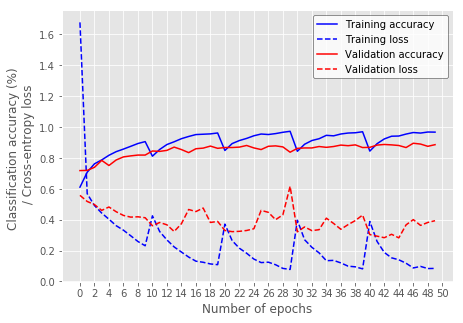

In [25]:
# Now plot
import matplotlib.pyplot as plt


epochs = np.arange(0, 51, 2.0)


plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (7,5)

plt.plot(historyArr['acc'], color='blue', linestyle='solid', label='Training accuracy')
plt.plot(historyArr['loss'], color='blue', linestyle='dashed', label='Training loss')

plt.plot(historyArr['val_acc'], color='red', linestyle='solid', label='Validation accuracy')
plt.plot(historyArr['val_loss'], color='red', linestyle='dashed', label='Validation loss')

plt.xlabel('Number of epochs')
plt.xticks(epochs)

plt.ylabel('Classification accuracy (%) \n / Cross-entropy loss')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()